In [1]:
import sys
import os

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, train_val_split, get_dimensions, scale, \
    metrics_r, get_device, plot_history

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train

## Set Working Device

In [5]:
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


## Read Features and Targets

In [6]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

In [7]:
targets = ["StartYear", "YearRange"]

In [8]:
X = read_features(path, f_type="tensors")
y = read_targets(path, targets, f_type="np")

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


In [9]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1719, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
	},
}


In [10]:
print_info_targets(y)

{
	train: 
		<class 'numpy.ndarray'>
		shape   = (1719, 2)
	test: 
		<class 'numpy.ndarray'>
		shape   = (191, 2)
}


## Train-Validation Split

In [11]:
X, y = train_val_split(X, y)

In [12]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1547, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([172, 768]), 
	},
	test: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
		

In [13]:
print_info_targets(y)

{
	train: 
		<class 'numpy.ndarray'>
		shape   = (1547, 2)
	val: 
		<class 'numpy.ndarray'>
		shape   = (172, 2)
	test: 
		<class 'numpy.ndarray'>
		shape   = (191, 2)
}


## Scale Regression Targets

In [14]:
y, y_scaler = scale(y)

In [15]:
y = {subset: torch.tensor(_y, dtype=torch.float32, device=device) for subset, _y in y.items()}
print_info_targets(y)

{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1547, 2])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([172, 2])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191, 2])
}


## Dimensions

In [16]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


## Torch Datasets and Dataloaders

In [17]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Initialize Model



In [18]:
hidden_size = 256

models = {
             ft: PotteryChronologyPredictor([X_dim[ft]], y_dim, hidden_size, device, chronology_target="years")
             for ft in feature_types
         } | {
             ft_txt + " + " + ft_img: PotteryChronologyPredictor([X_dim[ft_txt], X_dim[ft_img]], y_dim, hidden_size, device, chronology_target="years")
             for ft_txt, ft_img in feature_type_combos
         }

In [19]:
for ft, model in models.items():
    print(f"\n\nMODEL SUMMARY - FEATURE TYPE: {ft.upper()}")
    model.summary()



MODEL SUMMARY - FEATURE TYPE: TFIDF
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 256]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 256]                  77,056                    77,056
│    │    └─ReLU: 3-2                    [1, 256]                  [1, 256]                  --                        --
│    │    └─Dropout: 3-3                 [1, 256]                  [1, 256]                  --                        --
├─Sequential: 1-2                        [1, 256]                  [1, 2]                    --  

## Train Model



** FEATURE SET: TFIDF **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1239.94it/s, loss=0.7256]


** Early Stopping
** Restore Model State at Epoch 6
** Final Model:
   train_loss: 0.5382
   val_loss: 0.6956
   target0: [mae: 38.0001, rmse: 50.4422, r2: 0.4907, medae: 29.4978]
   target1: [mae: 10.4226, rmse: 12.6863, r2: 0.2006, medae: 9.5971]


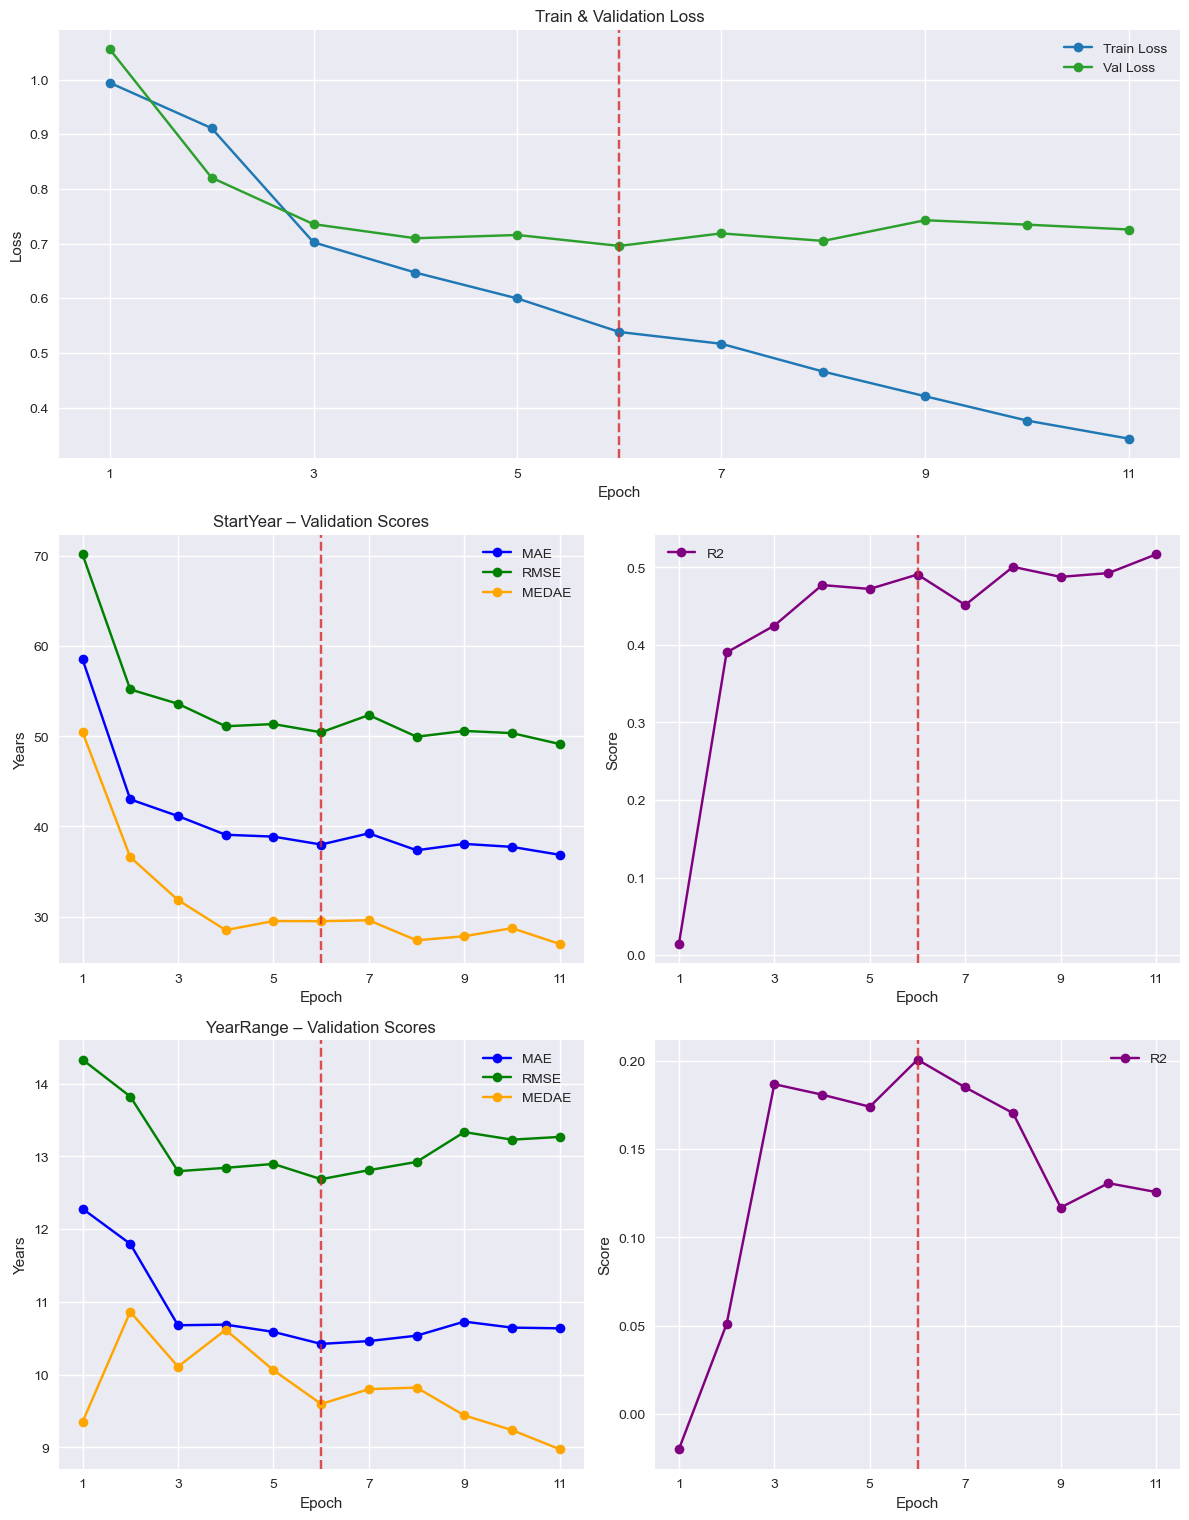



** FEATURE SET: BERT **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1387.16it/s, loss=0.8533]


** Early Stopping
** Restore Model State at Epoch 19
** Final Model:
   train_loss: 0.6792
   val_loss: 0.8182
   target0: [mae: 45.9459, rmse: 57.6890, r2: 0.3339, medae: 39.6694]
   target1: [mae: 11.1645, rmse: 13.5426, r2: 0.0890, medae: 10.9475]


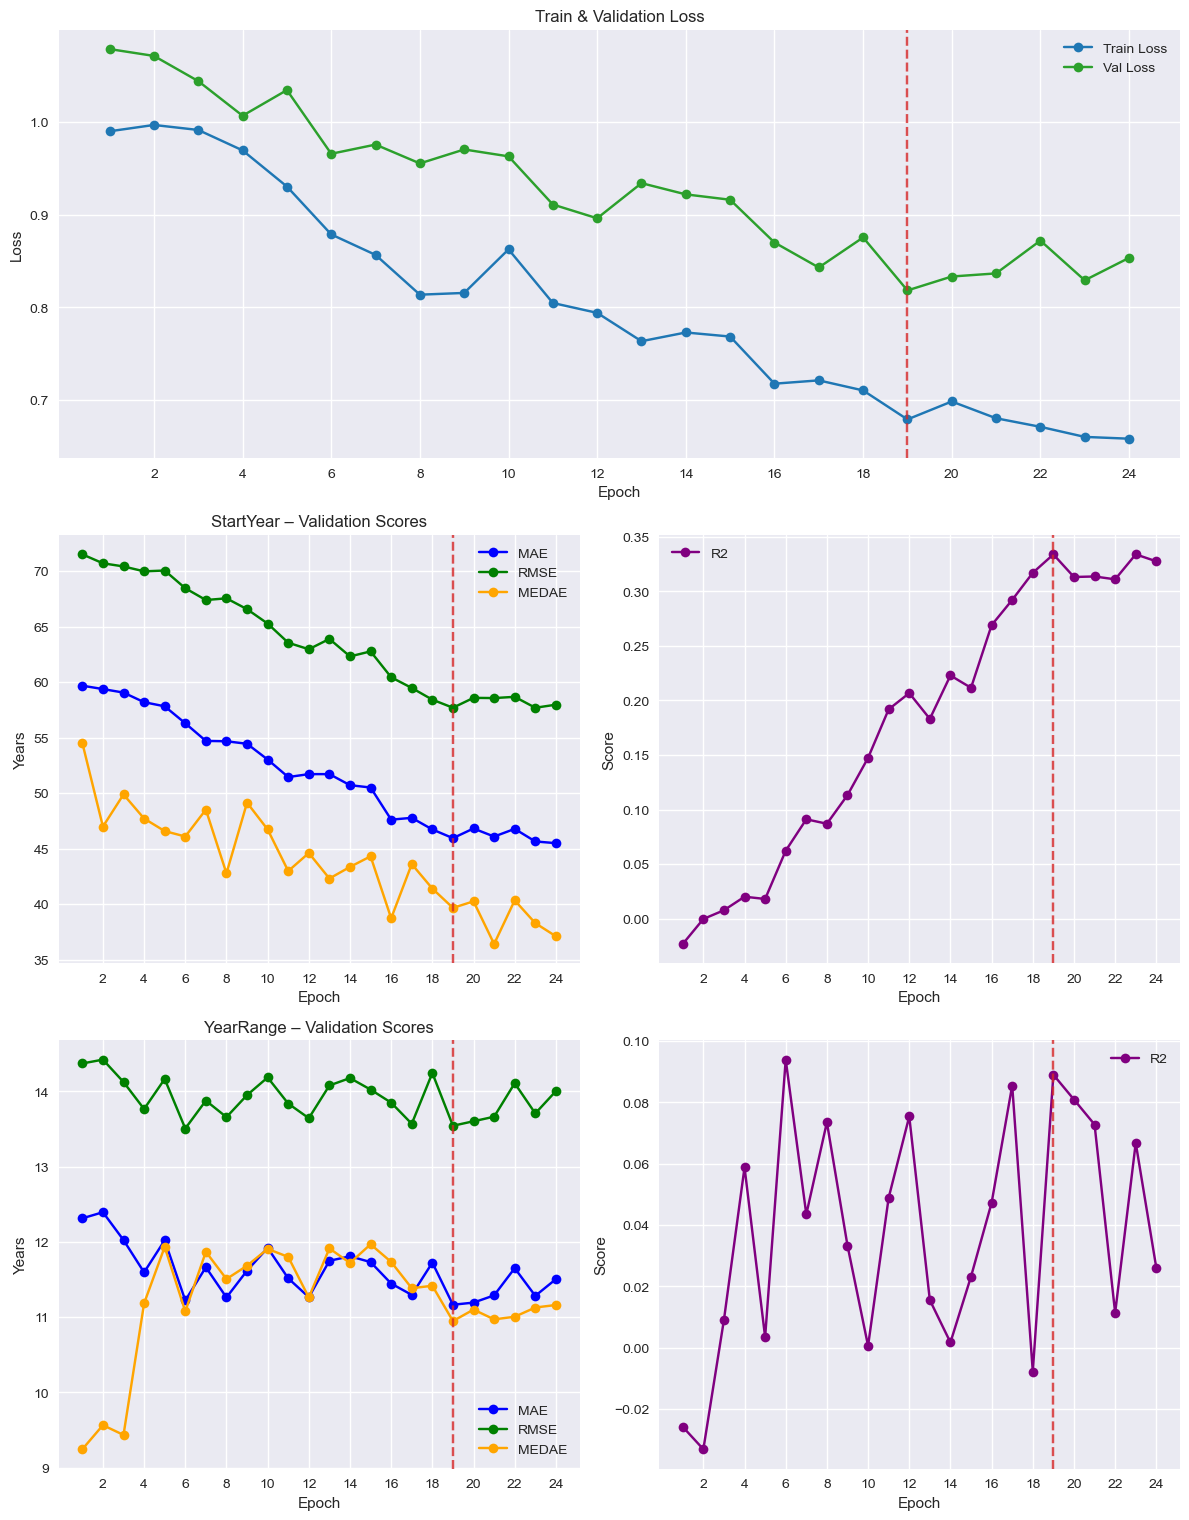



** FEATURE SET: CANNYHOG **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 959.36it/s, loss=1.0781]


** Early Stopping
** Restore Model State at Epoch 2
** Final Model:
   train_loss: 1.0196
   val_loss: 1.0689
   target0: [mae: 59.4648, rmse: 71.3305, r2: -0.0184, medae: 55.4939]
   target1: [mae: 12.0556, rmse: 14.2610, r2: -0.0102, medae: 8.2566]


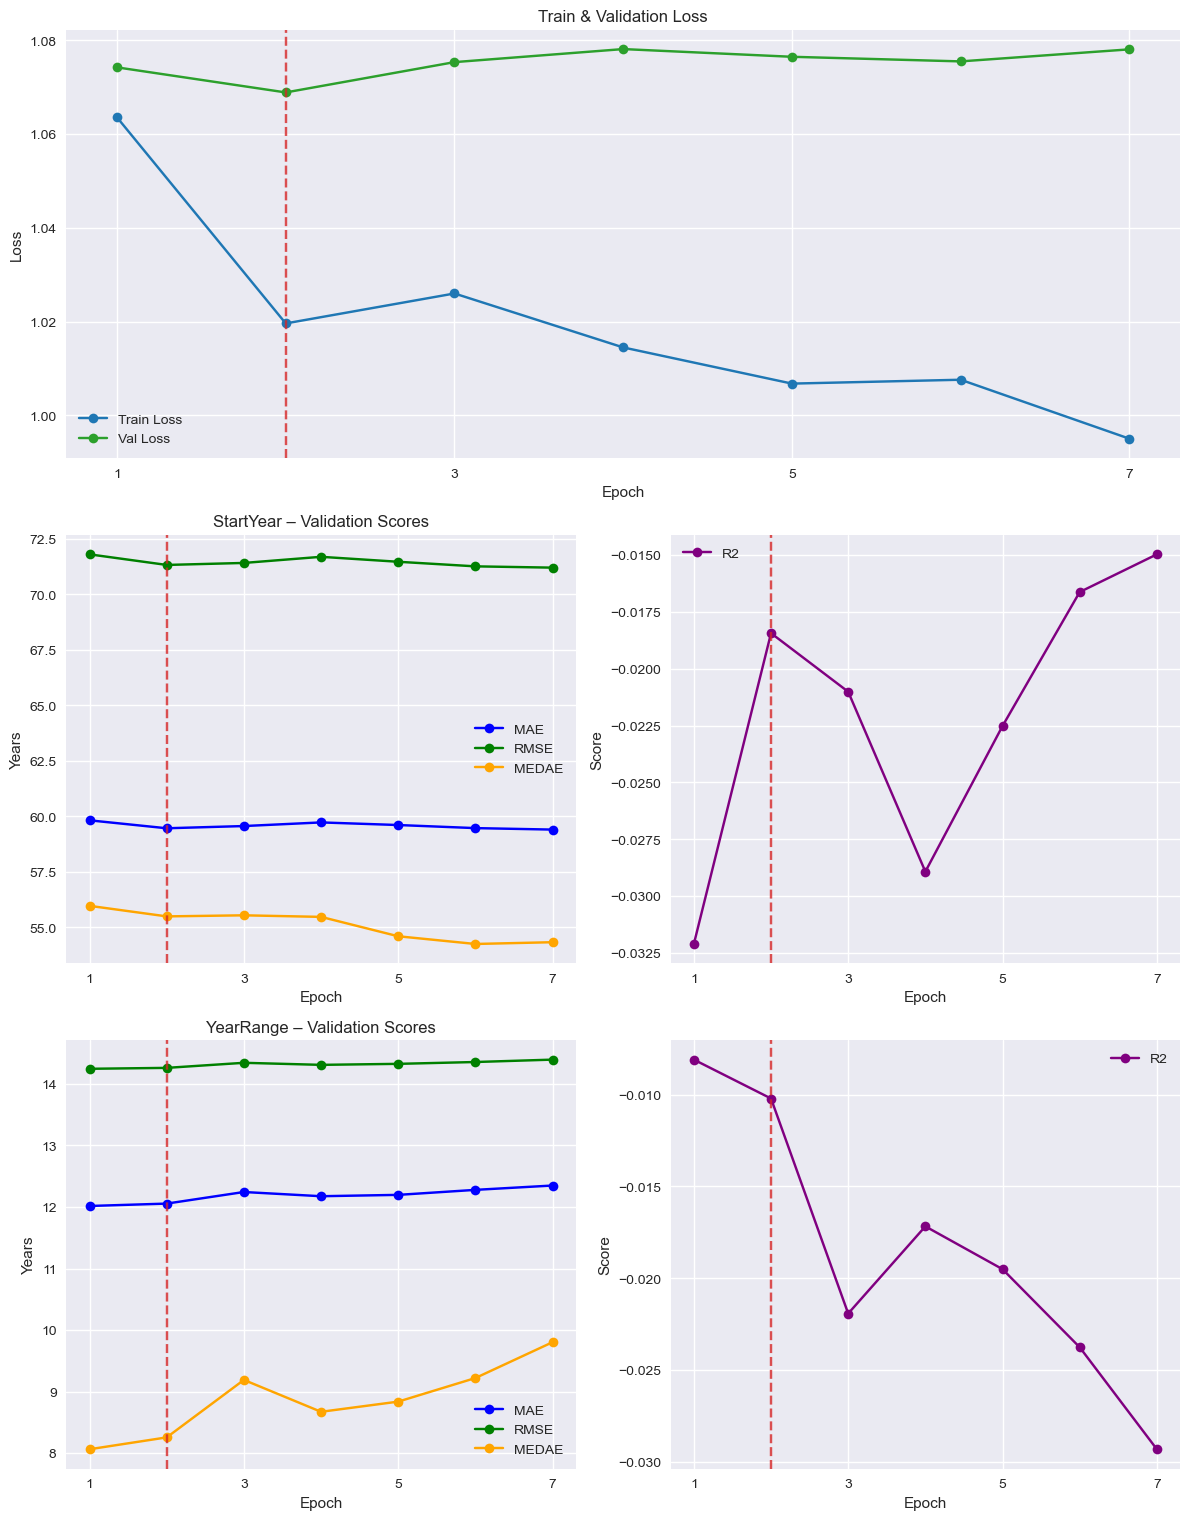



** FEATURE SET: RESNET **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1200.09it/s, loss=0.9552]


** Early Stopping
** Restore Model State at Epoch 11
** Final Model:
   train_loss: 0.7512
   val_loss: 0.9407
   target0: [mae: 49.2635, rmse: 62.0432, r2: 0.2295, medae: 43.4860]
   target1: [mae: 12.2964, rmse: 14.4607, r2: -0.0387, medae: 10.0645]


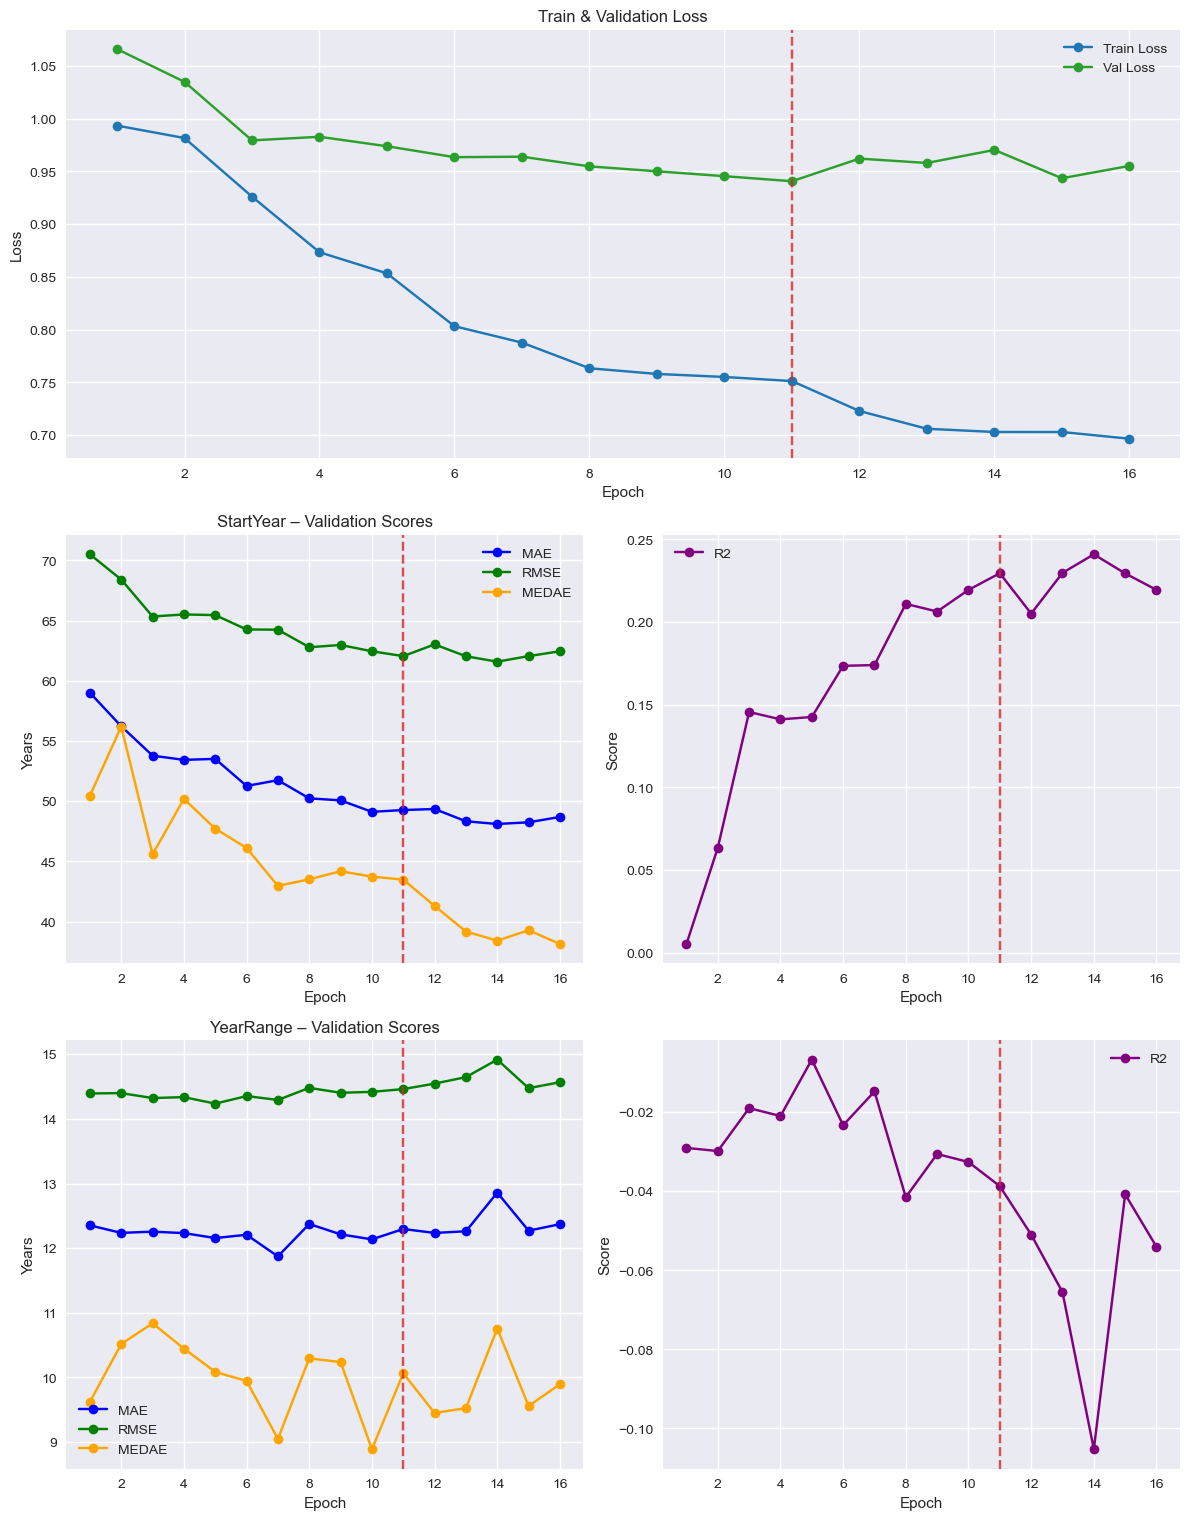



** FEATURE SET: VIT **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 857.20it/s, loss=0.9439]


** Early Stopping
** Restore Model State at Epoch 11
** Final Model:
   train_loss: 0.7894
   val_loss: 0.9137
   target0: [mae: 49.0193, rmse: 61.8960, r2: 0.2332, medae: 42.7642]
   target1: [mae: 11.5482, rmse: 14.0536, r2: 0.0189, medae: 8.2619]


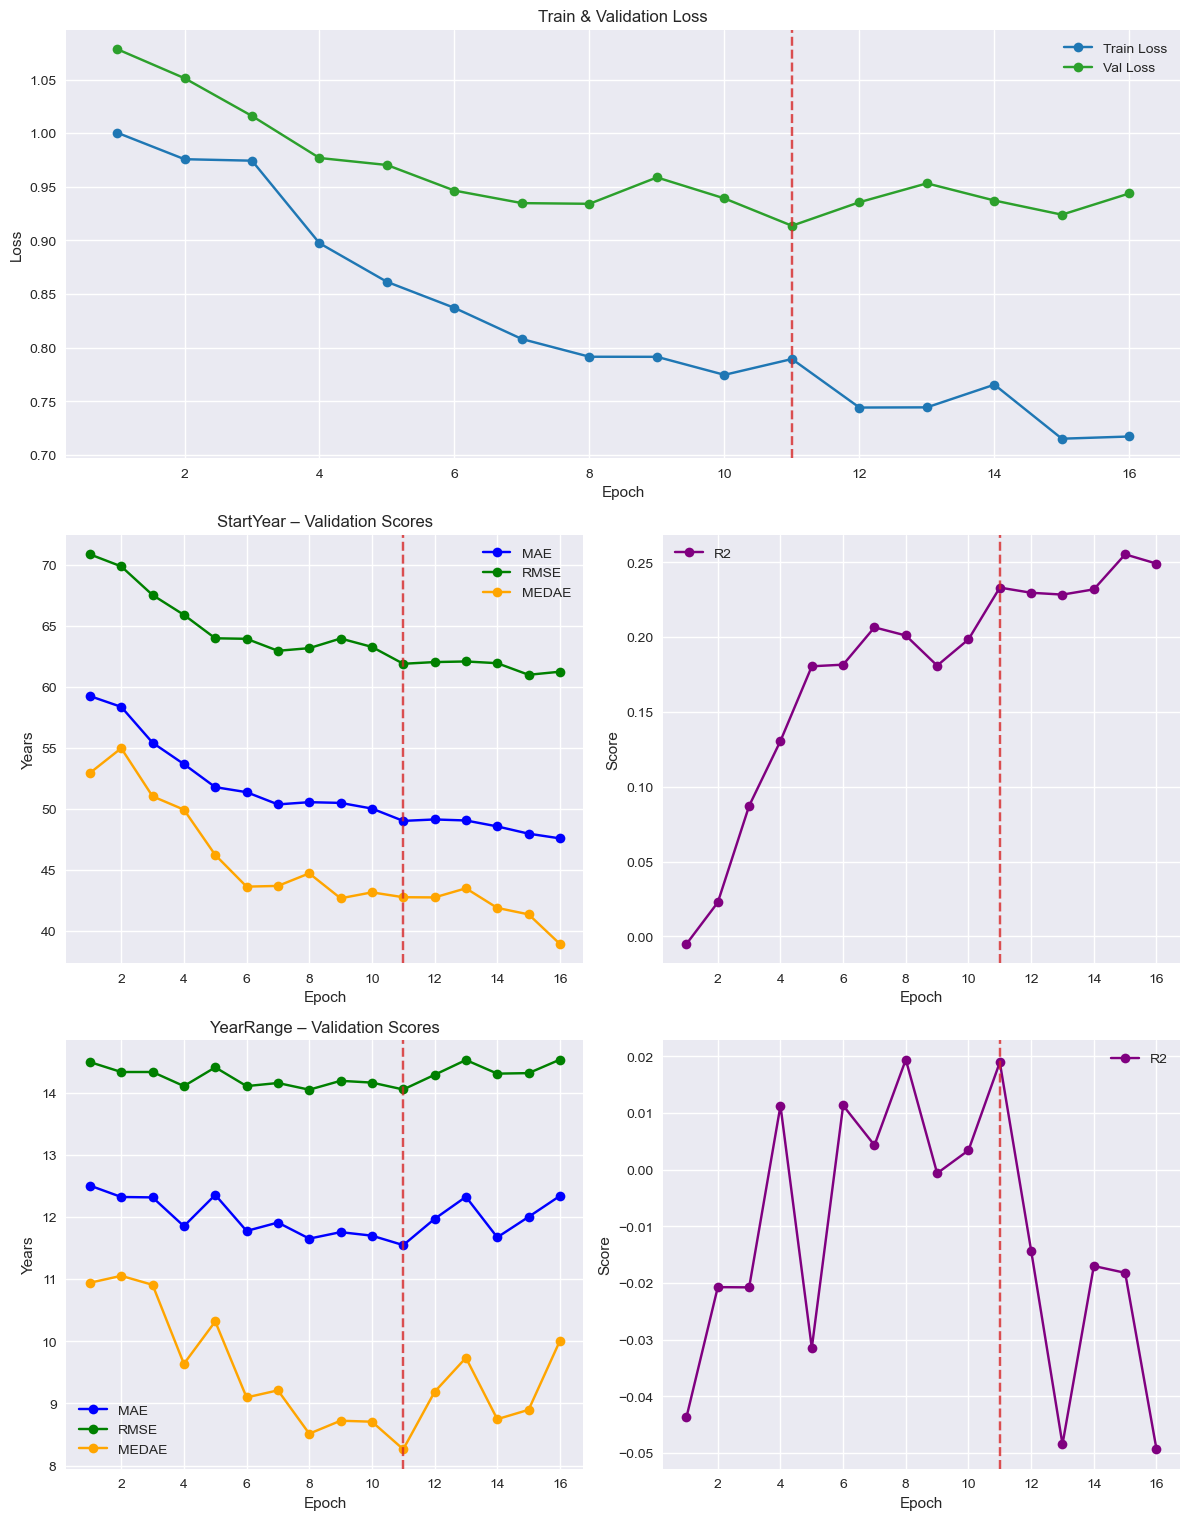



** FEATURE SET: TFIDF + CANNYHOG **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 530.86it/s, loss=0.7238]


** Early Stopping
** Restore Model State at Epoch 8
** Final Model:
   train_loss: 0.6159
   val_loss: 0.7233
   target0: [mae: 40.8266, rmse: 52.7355, r2: 0.4433, medae: 29.3273]
   target1: [mae: 10.6398, rmse: 12.7765, r2: 0.1891, medae: 10.5354]


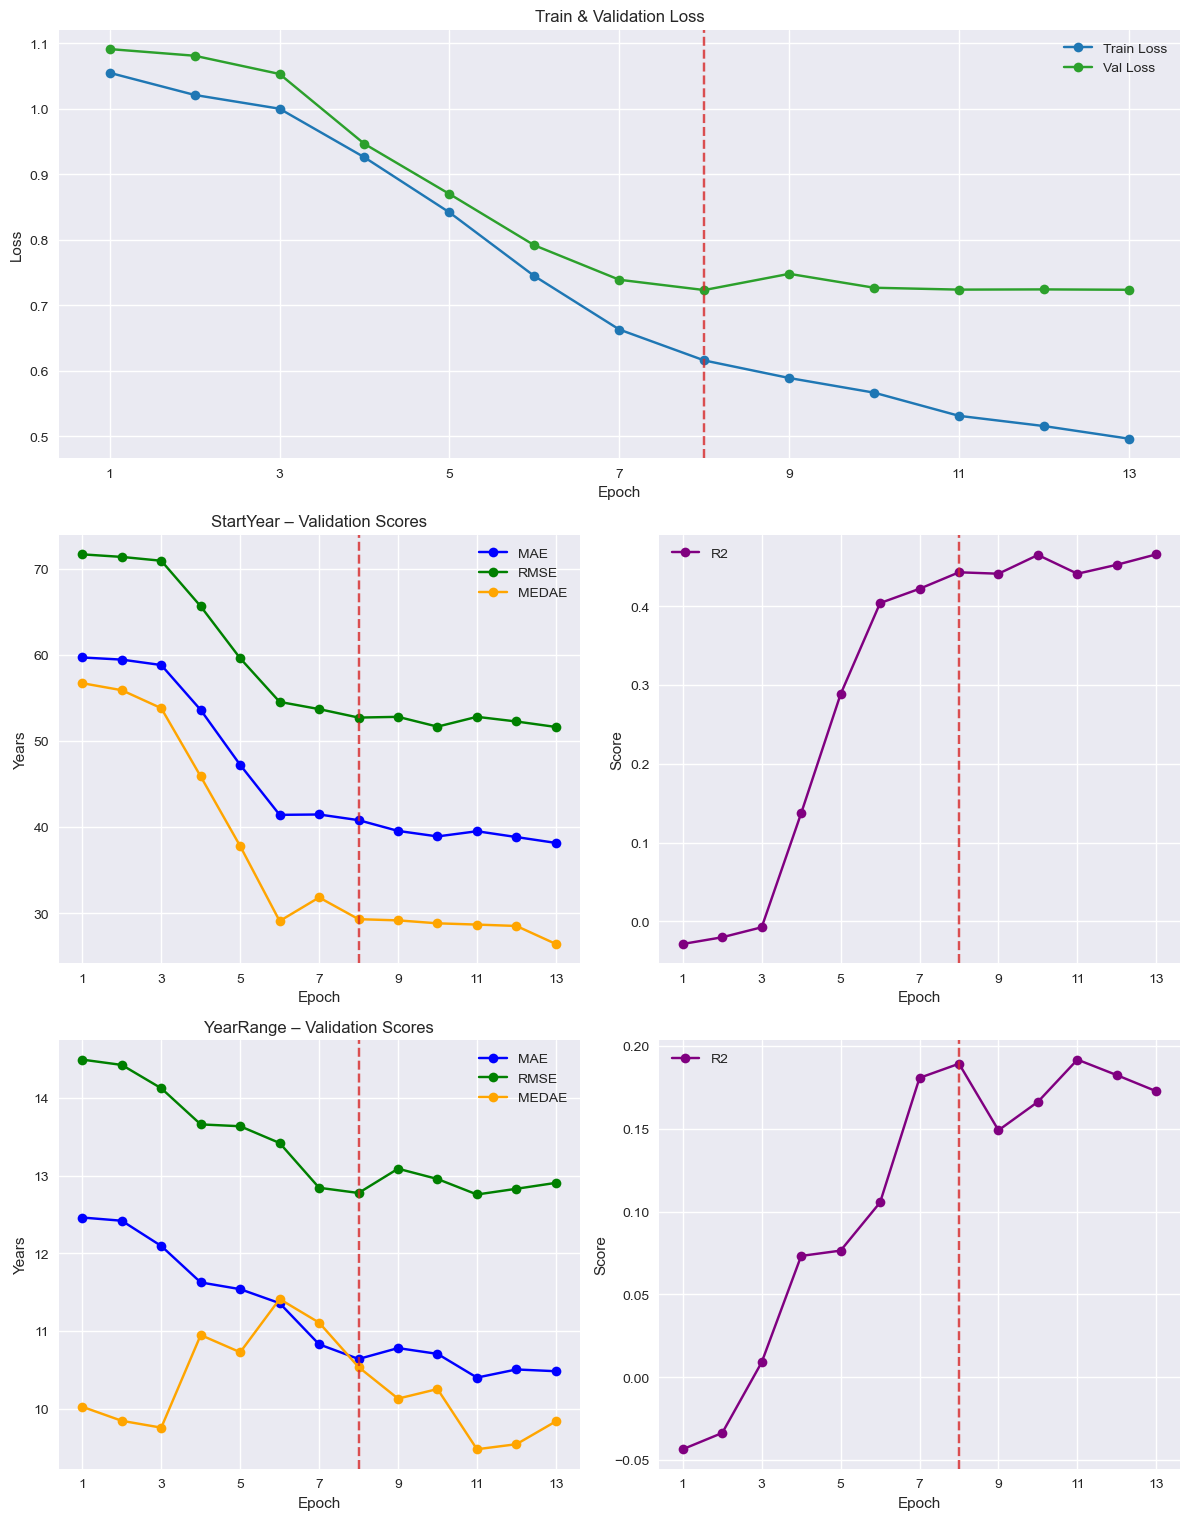



** FEATURE SET: TFIDF + RESNET **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1111.76it/s, loss=0.7137]


** Early Stopping
** Restore Model State at Epoch 11
** Final Model:
   train_loss: 0.3593
   val_loss: 0.6416
   target0: [mae: 34.1528, rmse: 44.2753, r2: 0.6076, medae: 26.1999]
   target1: [mae: 10.4085, rmse: 12.9030, r2: 0.1730, medae: 8.4208]


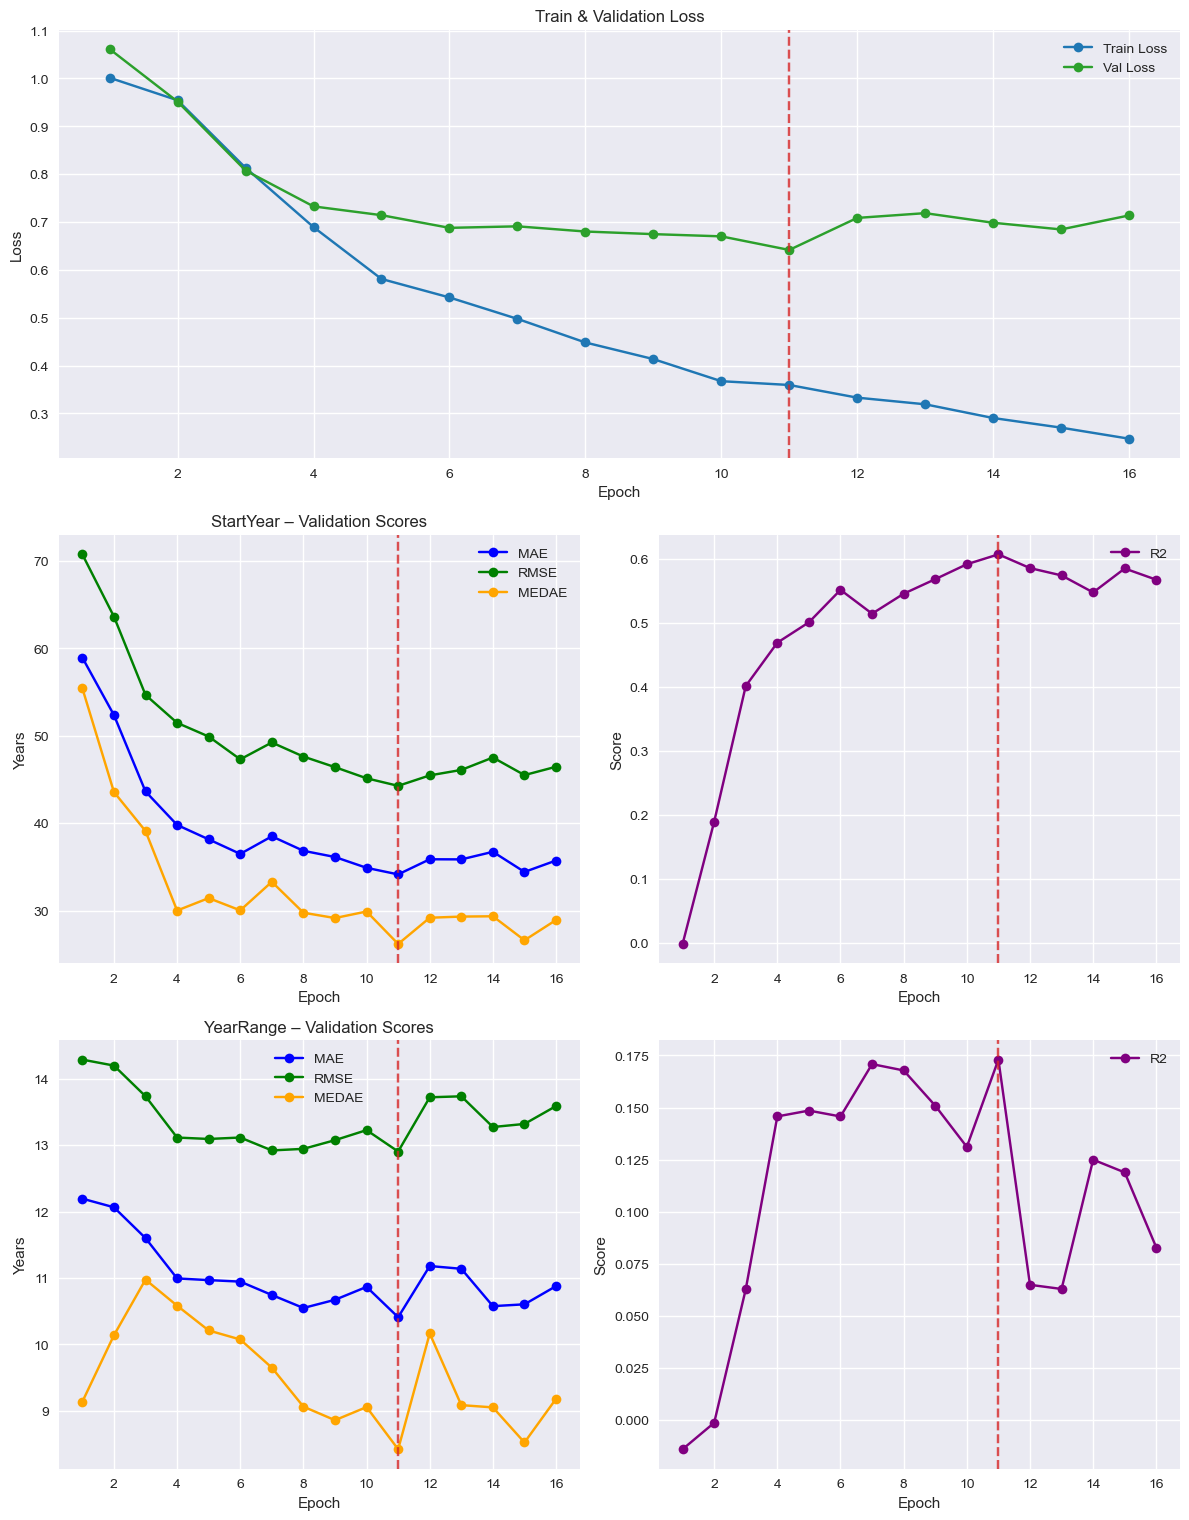



** FEATURE SET: TFIDF + VIT **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 879.06it/s, loss=0.7087]


** Early Stopping
** Restore Model State at Epoch 8
** Final Model:
   train_loss: 0.4600
   val_loss: 0.6731
   target0: [mae: 36.2956, rmse: 46.9701, r2: 0.5584, medae: 27.1039]
   target1: [mae: 10.6101, rmse: 12.9515, r2: 0.1668, medae: 9.4068]


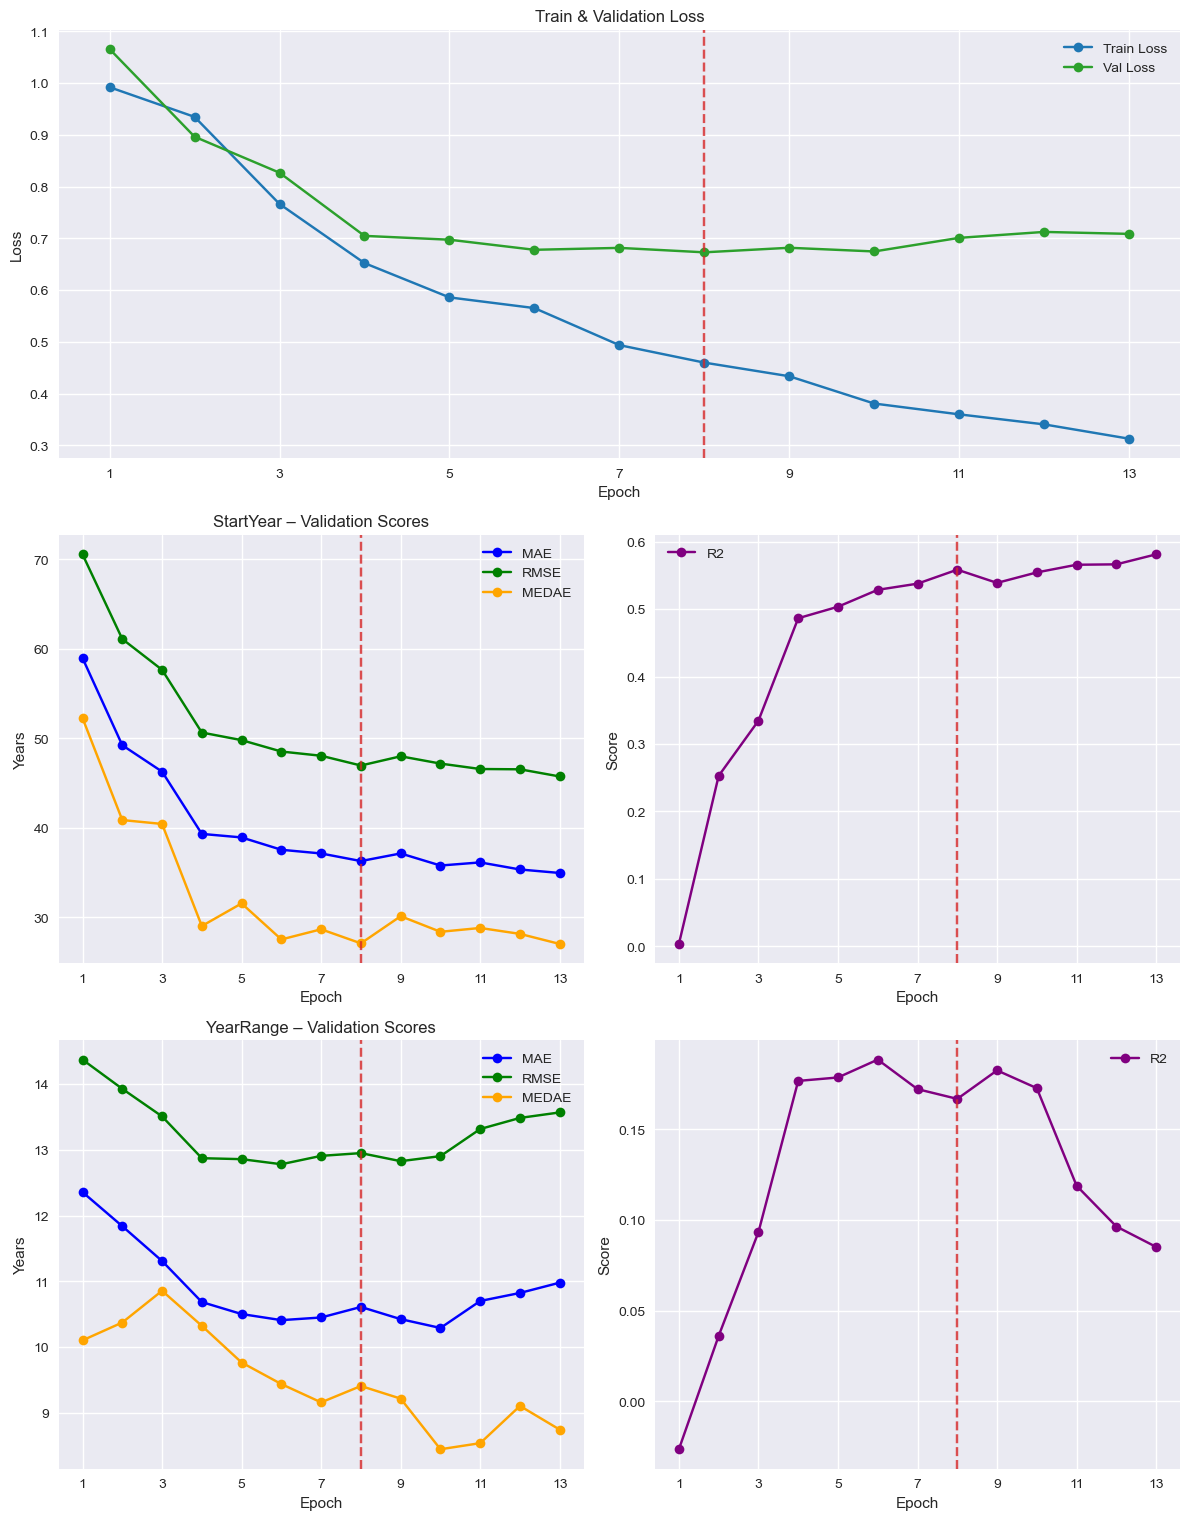



** FEATURE SET: BERT + CANNYHOG **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 847.22it/s, loss=0.8946]


** Early Stopping
** Restore Model State at Epoch 18
** Final Model:
   train_loss: 0.7854
   val_loss: 0.8767
   target0: [mae: 51.1330, rmse: 62.5006, r2: 0.2181, medae: 45.1503]
   target1: [mae: 11.0670, rmse: 13.4177, r2: 0.1057, medae: 10.8168]


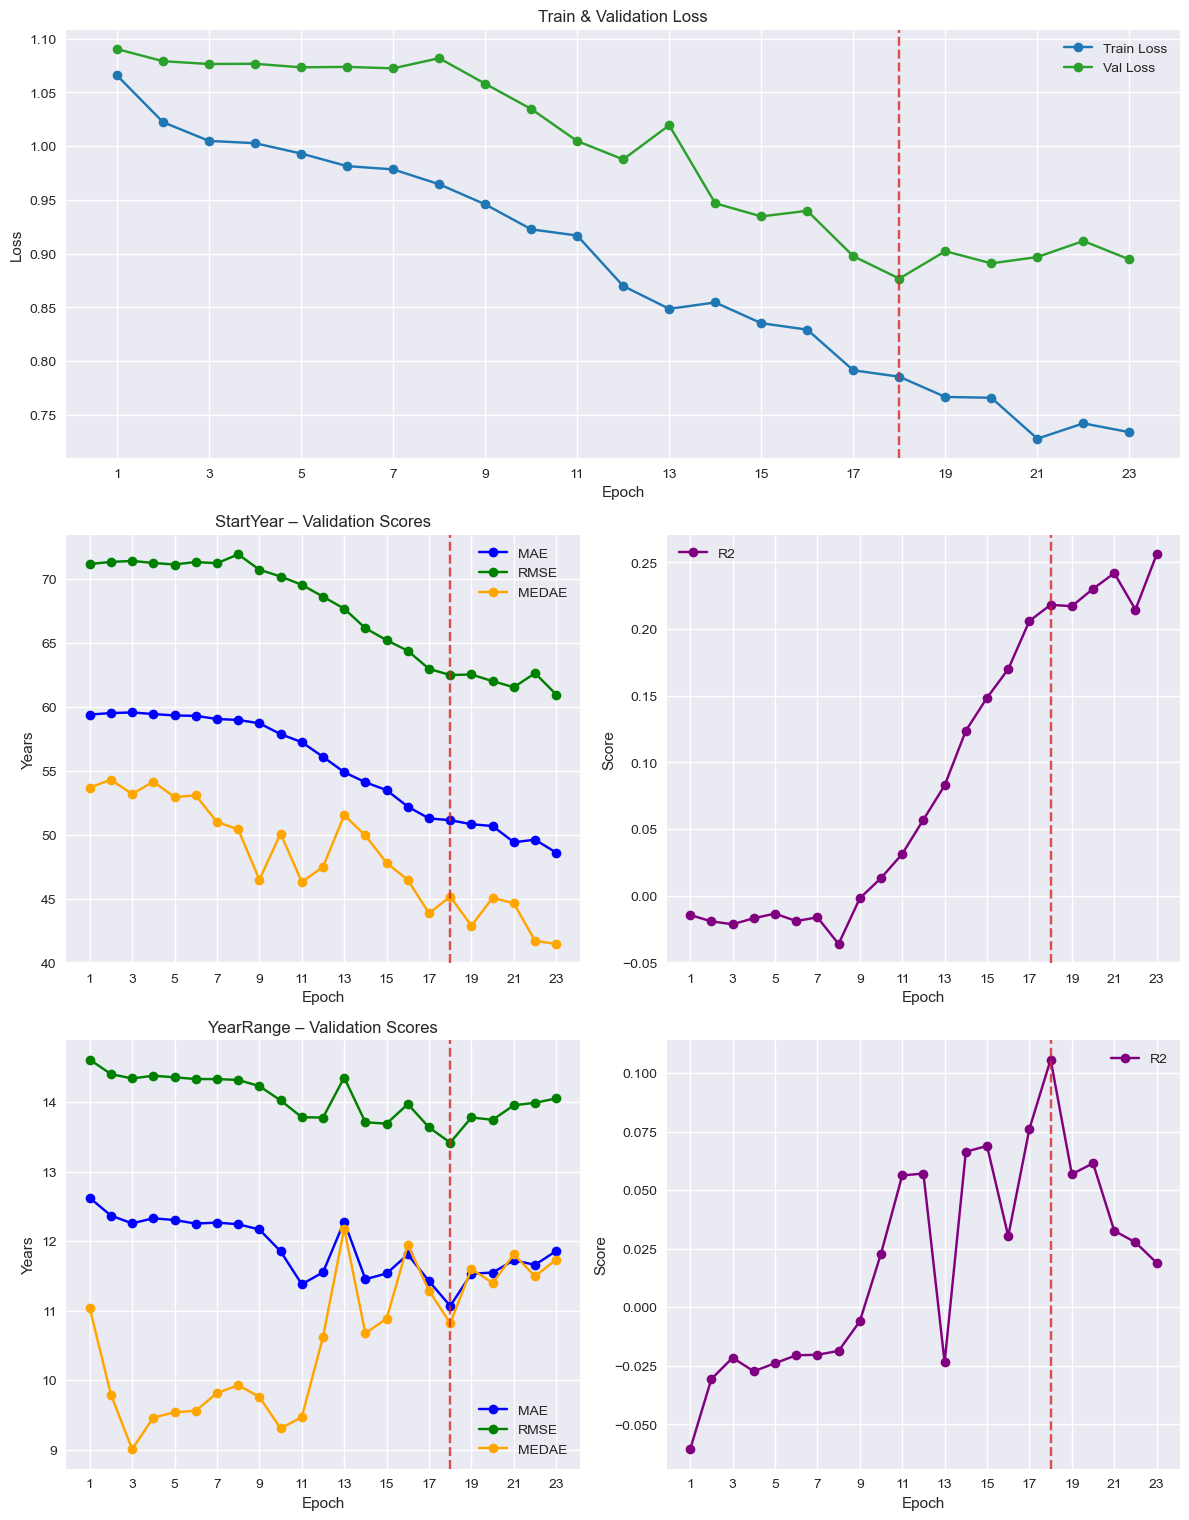



** FEATURE SET: BERT + RESNET **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 957.39it/s, loss=0.8542]


** Early Stopping
** Restore Model State at Epoch 10
** Final Model:
   train_loss: 0.6795
   val_loss: 0.8233
   target0: [mae: 45.3697, rmse: 57.8534, r2: 0.3301, medae: 37.1331]
   target1: [mae: 11.2405, rmse: 13.6978, r2: 0.0680, medae: 10.5172]


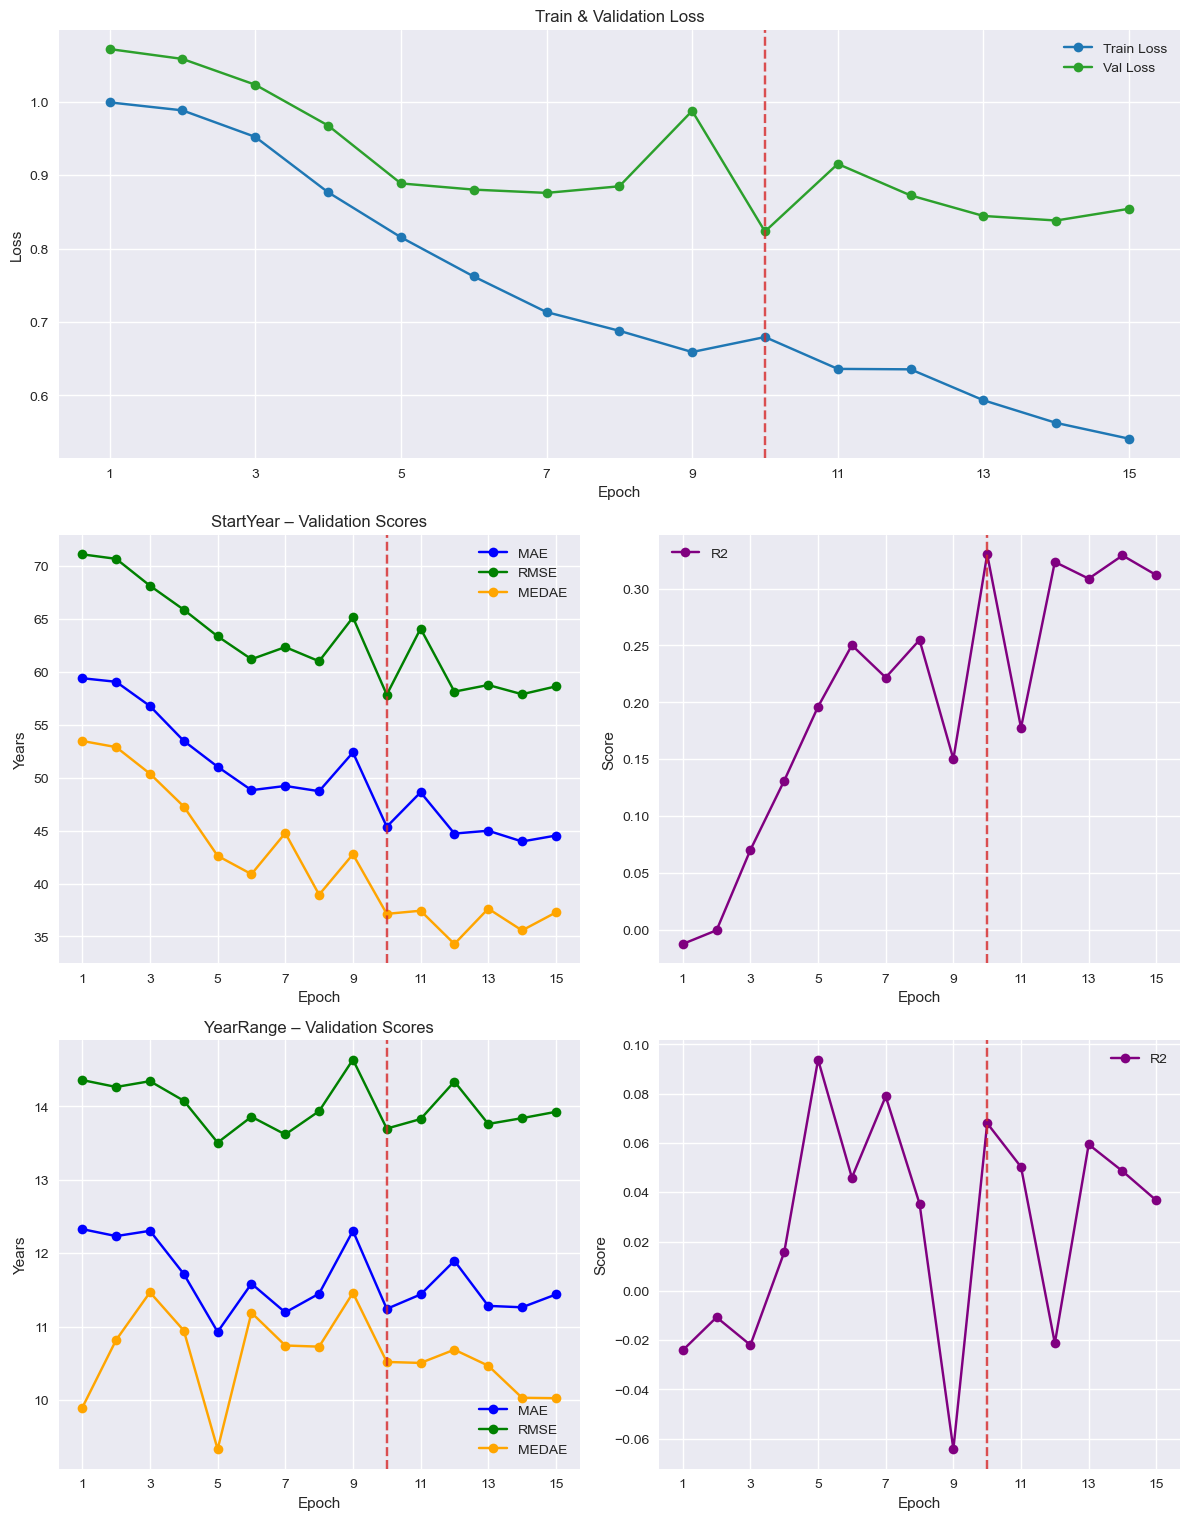



** FEATURE SET: BERT + VIT **


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 956.58it/s, loss=0.8052]


** Early Stopping
** Restore Model State at Epoch 16
** Final Model:
   train_loss: 0.6105
   val_loss: 0.8016
   target0: [mae: 43.6221, rmse: 56.2536, r2: 0.3666, medae: 37.5719]
   target1: [mae: 10.9811, rmse: 13.5273, r2: 0.0911, medae: 9.9884]


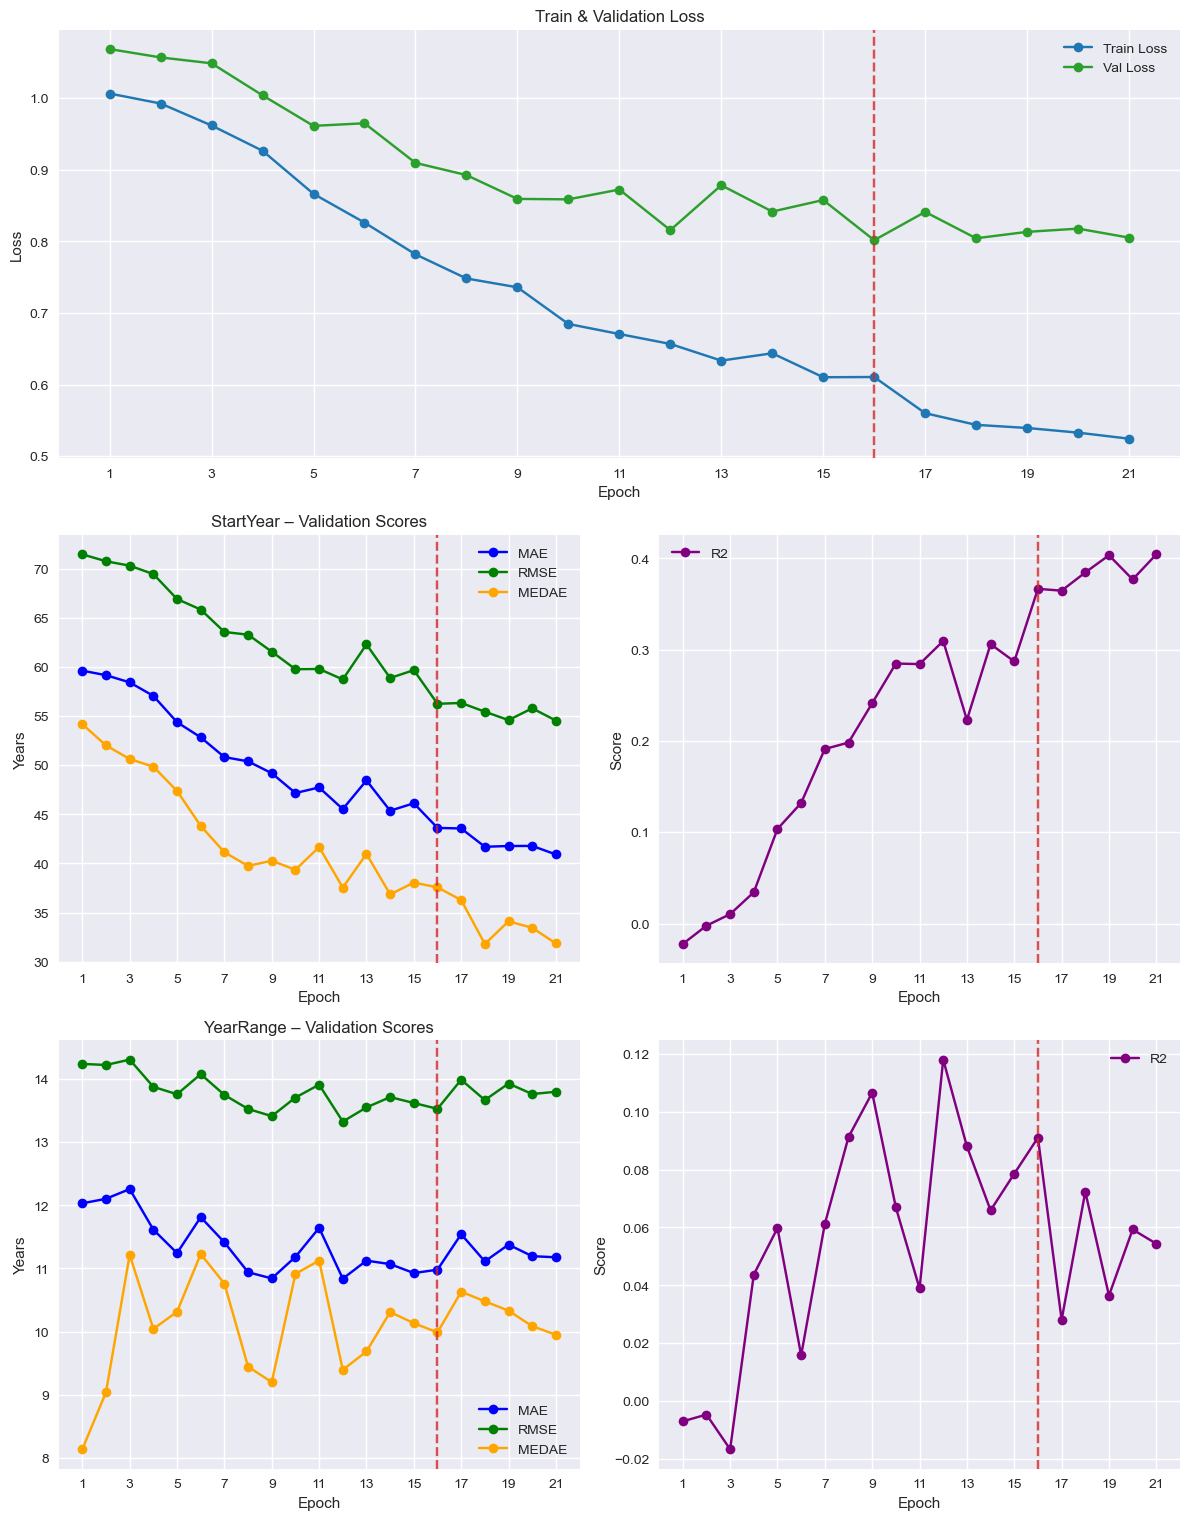

In [20]:
criterion = nn.MSELoss()
metrics = metrics_r

for ft, model in models.items():
    print(f"\n\n** FEATURE SET: {ft.upper()} **")
    models[ft], history = train(model, loaders["train"][ft], loaders["val"][ft], criterion, metrics, y_scaler)
    plot_history(history, targets)